В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

from process_bank_churn import preprocess_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [5]:
raw_df = pd.read_csv('train.csv')
X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(raw_df, scale_numeric=False)

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [8]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [10]:
#передбачення для AUROC
train_probs = knn.predict_proba(X_train)[:,1]
val_probs = knn.predict_proba(X_val)[:,1]

#AUROC
train_auc = roc_auc_score(train_targets, train_probs)
val_auc = roc_auc_score(val_targets, val_probs)

print(f"Train AUROC: {train_auc:.3f}")
print(f"Validation AUROC: {val_auc:.3f}")

Train AUROC: 0.810
Validation AUROC: 0.559


На перший погляд результати не дуже, бо великий розрив між трейн та вал. Спочатку я припустила, що причина розриву через кількість трейн(12000), а вал(3000), але це не є чимось глобальним.
Трейн модель добре розрізняє класи на тренуванні, а валідаційна модель - гірша. 
Можливо вирішенням проблеми є правильний підбір n_neighbors у наступному кроці.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [77]:
from sklearn.model_selection import GridSearchCV

In [79]:
#задаю параметри для n_neighbors
params_knn = {'n_neighbors': range(1, 25)}

#крос валідація cv = 5
knn_gs = GridSearchCV(knn, params_knn, cv=5, scoring='roc_auc')

#Навчання на тренувальних  з допомогою AUROC
knn_gs.fit(X_train, train_targets)

print(knn_gs.best_params_)
print(knn_gs.best_score_)

{'n_neighbors': 24}
0.5753316028735824


In [81]:
#найкращи модель
knn_best = knn_gs.best_estimator_
knn_best

KNeighborsClassifier(n_neighbors=24)

In [83]:
#треную найкращу модель на валідаційних та тренувальних даних

y_train_probs = knn_best.predict_proba(X_train)[:,1]
y_val_probs = knn_best.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, y_train_probs)
val_auc = roc_auc_score(val_targets, y_val_probs)

print("Train AUROC:", val_auc)
print("Val AUROC:", val_auc)


Train AUROC: 0.6049701625625901
Val AUROC: 0.6049701625625901


Валідаційні дані: модель відрізняється від попередніх результатів на 0.05. Було 0.559 стало 0.60, тобто модель стала краще працювати

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [87]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

1) max_depth від 1 до 20 з кроком 2

In [90]:
#фіксую random_state для моделі
dt = DecisionTreeClassifier(random_state=42)

#задаю параметри для max_depth від 1 до 20 з кроком 2
params = {'max_depth': np.arange(1, 21, 2)}

#задаю GridSearchCV для dt, cv=3
dt_gs = GridSearchCV(dt, params, cv=3, scoring='roc_auc')

#Навчання на тренувальних  з допомогою AUROC
dt_gs.fit(X_train, train_targets)

print(dt_gs.best_params_)

{'max_depth': 5}


In [92]:
#зберегла найкращі параметри
dt_best = dt_gs.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=5, random_state=42)

In [94]:
#треную найкращі значення параметра на валідаційних даних
y_train_probs = dt_best.predict_proba(X_train)[:,1]
y_val_probs = dt_best.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, y_train_probs)
val_auc = roc_auc_score(val_targets, y_val_probs)

print("Train AUROC:", val_auc)
print("Val AUROC:", val_auc)


Train AUROC: 0.921863639481446
Val AUROC: 0.921863639481446


2) max_leaf_nodes від 2 до 10 з кроком 1

In [99]:
#фіксую random_state для моделі
dt = DecisionTreeClassifier(random_state=42)

#задаю параметри для max_depth від 2 до 10 з кроком 2
params = {'max_leaf_nodes': np.arange(2, 11, 1)}

#задаю GridSearchCV для dt, cv=3
dt_gs_1 = GridSearchCV(dt, params, cv=3, scoring='roc_auc')

#Навчання на тренувальних  з допомогою AUROC
dt_gs_1.fit(X_train, train_targets)

print(dt_gs_1.best_params_)

{'max_leaf_nodes': 10}


In [101]:
#зберегла найкращі параметри
dt_best_1 = dt_gs_1.best_estimator_
dt_best_1

DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)

In [103]:
#треную найкращі значення параметра на валідаційних даних
y_train_probs = dt_best_1.predict_proba(X_train)[:,1]
y_val_probs = dt_best_1.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, y_train_probs)
val_auc = roc_auc_score(val_targets, y_val_probs)

print("Train AUROC:", val_auc)
print("Val AUROC:", val_auc)


Train AUROC: 0.9002184649152891
Val AUROC: 0.9002184649152891


Порівнюючи ці дві моделі, ми бачимо, що друга модель на валідаційних даних показує на 0.02 менше. Загалом різниця не супер критична, але якщо обирати. то я обрала б першу моделі по DT max_depth від 1 до 20 з кроком 2 при якому Val AUROC: 0.92

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [118]:
from sklearn.model_selection import RandomizedSearchCV
import time

In [112]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [128]:
#фіксую random_state для моделі
dt = DecisionTreeClassifier(random_state=42)

#задаю всі параметри для RandomizedSearchCV
search = RandomizedSearchCV(
    dt,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring="roc_auc",
    verbose=3,
    refit=True
)

#вимірювання скільки часу потребує пошук оптимальних гіперпараметрів
start_time = time.time()
search.fit(X_train, train_targets)
end_time = time.time()

#виводжу результат по часу
print(f"Час пошуку: {end_time - start_time:.2f} секунд")

print("Найкращі параметри:", search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END criterion=entropy, max_depth=3, max_features=log2, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=10, splitter=random;, score=0.689 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=3, max_features=log2, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=10, splitter=random;, score=0.685 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=3, max_features=log2, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=10, splitter=random;, score=0.682 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=6, max_features=sqrt, max_leaf_nodes=16, min_samples_leaf=1, min_samples_split=20, splitter=best;, score=0.753 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=6, max_features=sqrt, max_leaf_nodes=16, min_samples_leaf=1, min_samples_split=20, splitter=best;, score=0.798 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=6, max_features=sqrt, max_leaf_nodes=16, m

In [134]:
#збереження накращої моделі
dt_random_search_best = search.best_estimator_
dt_random_search_best

DecisionTreeClassifier(max_depth=19, max_leaf_nodes=12, min_samples_leaf=8,
                       min_samples_split=10, random_state=42)

In [136]:
#треную найкращі значення параметра на валідаційних даних
y_train_probs = dt_random_search_best.predict_proba(X_train)[:,1]
y_val_probs = dt_random_search_best.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, y_train_probs)
val_auc = roc_auc_score(val_targets, y_val_probs)

print("Train AUROC:", val_auc)
print("Val AUROC:", val_auc)

Train AUROC: 0.9069222854791139
Val AUROC: 0.9069222854791139


Результати дуже схожі до моделі max_leaf_nodes
У попередніх результатах dt_best в мене були такі результати: max_depth=5 та max_leaf_nodes=10.
При роботі з RandomizedSearchCV я отримала такі результати: max_depth=19, max_leaf_nodes=12.
Можна побачити, що у другому варіанті глибина стала більше, що включає більш ризиків перенавчання навідміну від першого варіанту, де глибина не така і глибока, тобто поверхневий зріз(якщо так можна сказати).
Також результати AUROC:
1) max_depth=5
Train AUROC: 0.921863639481446
Val AUROC:   0.921863639481446

2) max_leaf_nodes=10
Train AUROC: 0.9002184649152891
Val AUROC:   0.9002184649152891

3) RandomizedSearchCV при max_depth=19, max_leaf_nodes=12
Train AUROC: 0.9069222854791139
Val AUROC:   0.9069222854791139

По всім Val AUROC ми бачимо що вона ідентична до Train AUROC, що каже нам про стабільність та добре натреновану модель.
Яку обрати при виборі роботи? важко сказати точно, яка саме буде надійною, бо різниці сутєвої між ними зараз не бачу. Але RandomizedSearchCV доволі складна модель, тому я б відштовхувалась від простоти і це була б модель max_depth=5, до того ж вона має найвищий Val AUROC:   0.92

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [142]:
test_raw_df = pd.read_csv("test.csv")

In [145]:
from process_bank_churn_ import preprocess_new_data

In [148]:
preprocessed_test_df = preprocess_new_data(test_raw_df, scaler, encoder, scaler_numeric=False)

Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Binary columns: ['IsActiveMember', 'HasCrCard']
Categorical columns: ['Geography', 'Gender']


In [165]:
preprocessed_test_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,584.0,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.0,1.0,0.0,0.0,1.0
1,551.0,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,1.0,0.0,0.0,0.0,1.0
2,706.0,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,1.0,0.0,0.0,0.0,1.0
3,717.0,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.0,0.0,1.0,0.0,1.0
4,592.0,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.0,0.0,1.0,0.0,1.0


In [167]:
print("Колонки train:", X_train.columns.tolist())
print("Колонки test:", preprocessed_test_df.columns.tolist())

Колонки train: ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']
Колонки test: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [169]:
sample_submission = pd.read_csv('sample_submission.csv')

In [175]:
# Впорядковуємо колонки тесту так само, як у тренувальних даних
preprocessed_test_df = preprocessed_test_df.reindex(columns=X_train.columns, fill_value=0)

test_preds = dt_best.predict_proba(preprocessed_test_df)[:, 1]


In [180]:
# робимо передбачення для тестового набору
test_preds = dt_best.predict_proba(preprocessed_test_df)[:, 1]

print(test_preds)
sample_submission['Exited'] = test_preds

[0.23791103 0.02761341 0.02761341 ... 0.00892374 0.04173355 0.20459082]


In [186]:
sample_submission.to_csv('submission_.csv', index=False)

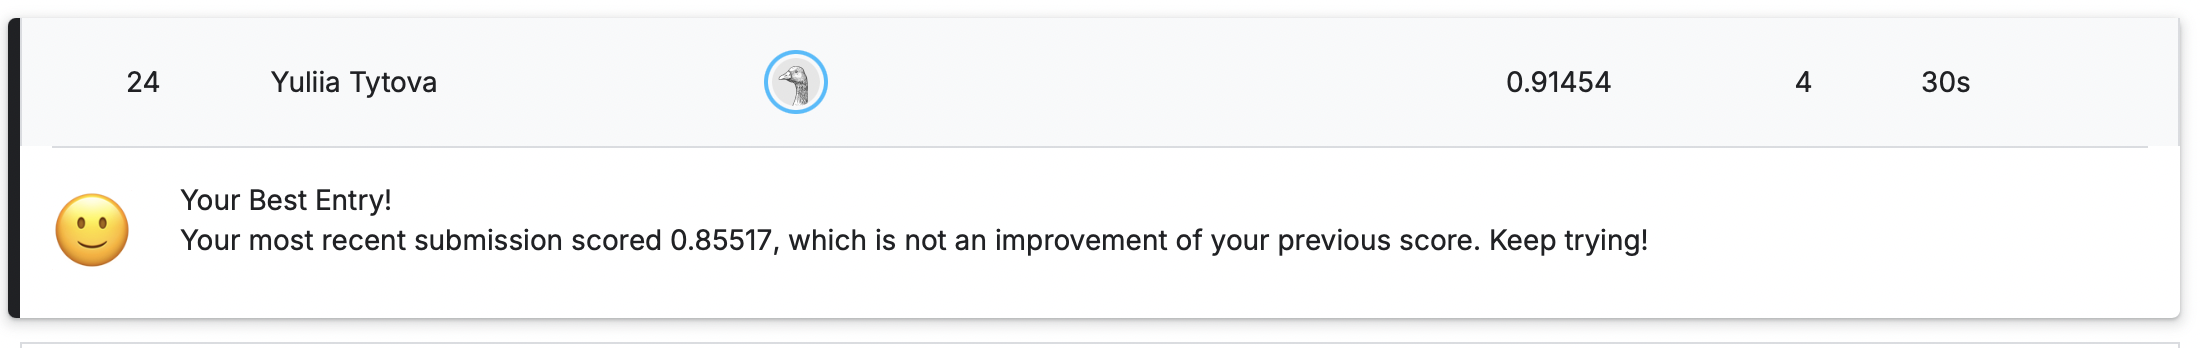